In [84]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [85]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [86]:
class Atanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()
        self.alpha = nn.Parameter(torch.tensor(0.9))

    def forward(self, x):
        return self.tanh(self.alpha * x)

In [87]:
class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0):
        super(FourierFeatures, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.B = nn.Parameter(scale * torch.randn(in_features, out_features), requires_grad=False)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        fourier = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return torch.cat([x, fourier], dim=-1) 

In [88]:
class Gate1(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.atanh = Atanh()
    
    def forward(self, x):
        return self.atanh(self.linear(x))

In [89]:
class Gate2(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.atanh = Atanh()
    
    def forward(self, x):
        return self.atanh(self.linear(x))

In [90]:
class Network(nn.Module):
    def __init__(self, num_input=2, fourier_features=10, layers=[64, 64, 64], num_output=1, scale=1.0):
        super().__init__()
        self.fourier = FourierFeatures(num_input, fourier_features, scale)
        input_size = num_input + 2*fourier_features
        self.input_layer = nn.Linear(input_size, layers[0])
        self.z_layers = nn.ModuleList()
        self.gate1 = Gate1(input_size, layers[0])
        self.gate2 = Gate2(input_size, layers[0])
        for i in range(len(layers)-1):
            self.z_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], num_output)
    def forward(self, x):
        x = self.fourier(x)
        U = self.gate1(x)
        V = self.gate2(x)
        h = torch.tanh(self.input_layer(x))
        for z_layer in self.z_layers:
            Z = torch.tanh(z_layer(h))
            h = (1 - Z) * U + Z * V
        return self.output_layer(h)

In [104]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)
        print("CUDA Available:", torch.cuda.is_available())
        initialize_weights(self.network)
        # Original domain parameters
        self.c_original = 80.0  # original transport velocity

        # Dimensionless parameters (after normalization)
        self.L_char = 2 * np.pi
        self.T_char = self.L_char / self.c_original
        self.c_star = 1.0

        # Domain Definition
        dt_star = 0.01
        dx_star = 0.01

        t_star_max = 1.0 / self.T_char

        # Dimensionless time and space domain
        self.t_star = torch.arange(0, t_star_max + dt_star, dt_star, device=self.device)
        self.x_star = torch.arange(0, 1 + dx_star, dx_star, device=self.device)

        # Create mesh in dimensionless coordinates
        self.TX_star = torch.stack(torch.meshgrid(self.t_star, self.x_star, indexing='ij')).reshape(2, -1).T
        self.TX_star = self.TX_star.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(),lr=1e-5)
        # ,lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.network.parameters(),
            lr=1.0,
            max_iter=1000,
            max_eval=1000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        # Plot-history
        self.loss_history = []

    def loss_f(self):
        # Restart Optimizer
        self.optimizer.zero_grad()

        # Network prediction in dimensionless coordinates
        self.u_pred = self.network(self.TX_star)
        self.u_P = self.u_pred.reshape(len(self.t_star), len(self.x_star))

        # Apply hard boundary conditions - Periodic boundary conditions
        self.u_P[:, 0] = self.u_P[:, -1]  # left = right (periodic)

        # Initial condition in dimensionless coordinates: u*(0,x*) = sin(2πx*)
        self.u_P[0, :] = torch.sin(2 * np.pi * self.x_star)

        # Finite difference calculations in dimensionless coordinates
        dt_star = self.t_star[1] - self.t_star[0]
        dx_star = self.x_star[1] - self.x_star[0]

        # Time derivative
        def central_diff_t(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - arr[:-2, :]) / (2 * dt_star)
            return res

        # Spatial derivative
        def central_diff_x(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - arr[:, :-2]) / (2 * dx_star)
            return res

        # Calculate derivatives
        du_dt = central_diff_t(self.u_P)
        du_dx = central_diff_x(self.u_P)

        # Extract interior points
        slice_in = slice(1, -1)
        du_dt_int = du_dt[slice_in, slice_in]
        du_dx_int = du_dx[slice_in, slice_in]

        # Compute PDE residuals
        advection_equ = du_dt_int + self.c_star * du_dx_int

        # Calculate loss
        self.loss = self.criterion(advection_equ.reshape(-1), torch.zeros_like(advection_equ).reshape(-1))

        self.loss.backward()
        return self.loss

    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.9f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/advection/3-FF-FD-PINNs-gated-avtivated-initialized/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)

    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            t_vals = self.t_star.detach().cpu().numpy()
            x_vals = self.x_star.detach().cpu().numpy()
            u_vals = self.u_P.detach().cpu().numpy()

        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        plt.figure(figsize=(6, 5))
        contour = plt.contourf(x_vals, t_vals, u_vals, levels=50, cmap="jet")
        cbar = plt.colorbar(contour)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        plt.xlabel("x", fontsize=14)
        plt.ylabel("t", fontsize=14)
        plt.title("Modified FD-PINNs", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/advection/3-FF-FD-PINNs-gated-avtivated-initialized/u_plot.png", dpi=300)
        plt.show()
        plt.close()

        # Compute analytical (exact) solution
        T_mesh, X_mesh = np.meshgrid(t_vals, x_vals, indexing='ij')
        u_exact = np.sin(2 * np.pi * (X_mesh - T_mesh))

        # Compute absolute error
        error = np.abs(u_vals - u_exact)

        plt.figure(figsize=(6, 5))
        contour2 = plt.contourf(x_vals, t_vals, error, levels=50, cmap="jet")
        cbar2 = plt.colorbar(contour2)
        cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2e"))
        plt.xlabel("x", fontsize=14)
        plt.ylabel("t", fontsize=14)
        plt.title("Absolute Error", fontsize=13)
        plt.savefig("C:/Users/hossein/Result/advection/3-FF-FD-PINNs-gated-avtivated-initialized/error_contour.png", dpi=300)
        plt.show()
        plt.close()
        
        
        cp2 = plt.contourf(x_vals, t_vals, u_exact, levels=50, cmap='jet')
        plt.colorbar(cp2)
        plt.title("Exact Solution",fontsize=13)
        plt.xlabel("x",fontsize=14)
        plt.ylabel("t",fontsize=14)
        plt.grid(True)

    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()

        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/advection/3-FF-FD-PINNs-gated-avtivated-initialized/loss_history5.csv", index=False)

CUDA Available: True
Iteration 0, Loss: 0.000000378
Iteration 10, Loss: 0.000002412
Iteration 20, Loss: 0.000000648
Iteration 30, Loss: 0.000000412
Iteration 40, Loss: 0.000000446
Iteration 50, Loss: 0.000000408
Iteration 60, Loss: 0.000000387
Iteration 70, Loss: 0.000000380
Iteration 80, Loss: 0.000000377
Iteration 90, Loss: 0.000000376
Iteration 100, Loss: 0.000000375
Iteration 110, Loss: 0.000000375
Iteration 120, Loss: 0.000000375
Iteration 130, Loss: 0.000000375
Iteration 140, Loss: 0.000000375
Iteration 150, Loss: 0.000000375
Iteration 160, Loss: 0.000000375
Iteration 170, Loss: 0.000000375
Iteration 180, Loss: 0.000000375
Iteration 190, Loss: 0.000000375
Iteration 200, Loss: 0.000000375
Iteration 210, Loss: 0.000000375
Iteration 220, Loss: 0.000000375
Iteration 230, Loss: 0.000000375
Iteration 240, Loss: 0.000000375
Iteration 250, Loss: 0.000000375
Iteration 260, Loss: 0.000000375
Iteration 270, Loss: 0.000000375
Iteration 280, Loss: 0.000000375
Iteration 290, Loss: 0.000000375


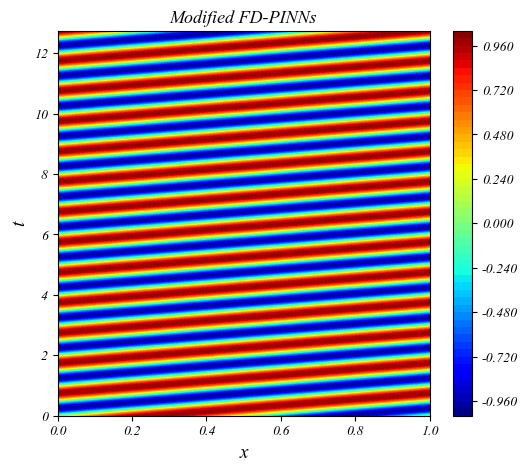

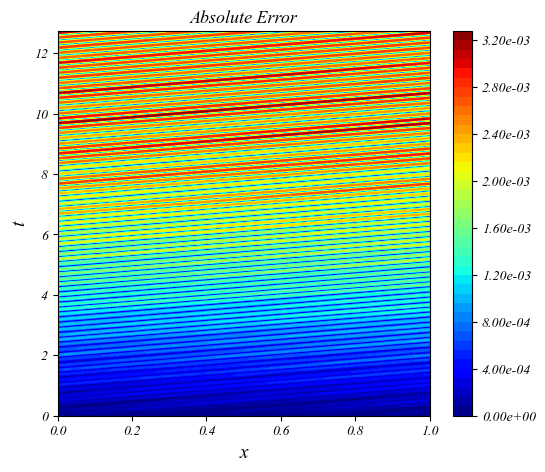

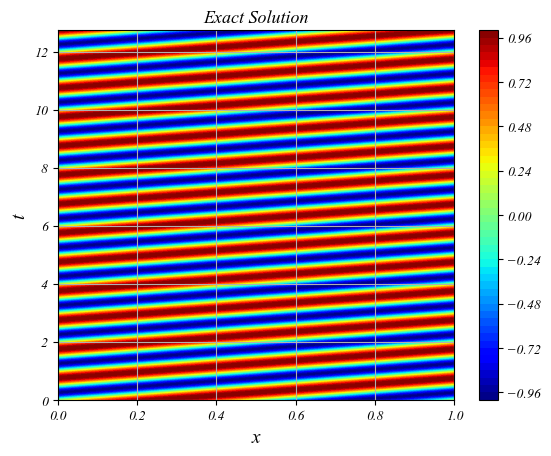

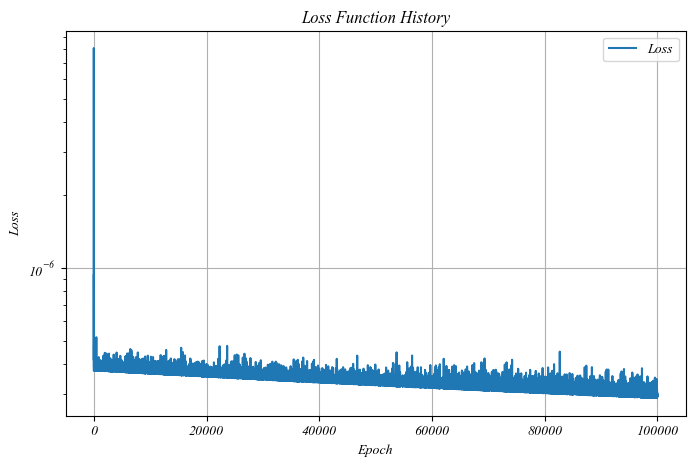

In [105]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/advection/3-FF-FD-PINNs-gated-avtivated-initialized/model'))
net.train(num_epochs=100000)
net.plot()
net.plot_loss()